In [1]:
import pandas as pd
import json
import numpy as np
from collections import defaultdict

In [2]:
df = pd.read_csv('./data/scraped.tsv', sep='\t')
df

,Company,Location,Date,Level,Title,YOE,TC,Base,Stock,Bonus,Details,Gender
0,Veracode,"Burlington, MA",1/30/2022,L1,API Development (Back-End),0 / 1,"$120,000",120k,NaN,NaN,"Remote, Title: Software Engineer, Race: White,...",Gender: Male
1,IBM,"Rochester, MN",1/30/2022,Staff Engineer,Distributed Systems (Back-End),0 / 0,"$112,000",112k,NaN,NaN,"$15,000 sign-on bonus, Title: Software Develop...",Gender: Male
2,Philips,"Cambridge, MA",1/30/2022,L4,Data,2 / 3,"$122,000",111k,NaN,11k,"10K Relocation Bonus, Title: Cloud Software De...",Gender: Male
3,Teleport,"Oakland, CA",1/30/2022,L3,Site Reliability (SRE),1 / 8,"$180,000",180k,NaN,NaN,"Title: Sre, Race: White, Academic Level: Bache...",Gender: Male
4,IBM,"Rochester, MN",1/30/2022,Advisory Engineer,API Development (Back-End),7 / 7,"$128,000",128k,NaN,NaN,"Title: Advisory Software Developer, Race: Whit...",Gender: Male
...,...,...,...,...,...,...,...,...,...,...,...,...
61218,Microsoft,"Seattle, WA",6/21/2017,63,8.5 / 8.5,"$208,000",NaN,NaN,NaN,NaN,NaN,NaN
61219,Amazon,"Seattle, WA",6/20/2017,L5,3 / 3,"$190,000",NaN,NaN,NaN,NaN,NaN,NaN
61220,Microsoft,"Mountain View, CA",6/20/2017,60,3 / 5,"$157,000",NaN,NaN,NaN,NaN,NaN,NaN
61221,Amazon,"Vancouver, BC, Canada",6/16/2017,L5,1 / 11,"$173,000",NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.replace('', np.nan, inplace=True)
df.replace('--', np.nan, inplace=True)

In [4]:
#Fix some rows that are misaligned
misaligned = df[df['YOE'].str.startswith('$')]

misaligned_corrected = pd.concat([
    misaligned[['Company', 'Location', 'Date']],
    misaligned.drop(['Company', 'Location', 'Date'], axis=1).shift(axis=1)
], axis=1).fillna('')

df.update(misaligned_corrected)

In [5]:
misaligned = df[df['Base'].str.len() > 5]
misaligned_cols = ['Base', 'Stock', 'Bonus', 'Details', 'Gender']

misaligned_corrected = pd.concat([
    misaligned.drop(misaligned_cols, axis=1),
    misaligned[misaligned_cols].shift(periods=3, axis=1)
], axis=1).fillna('')

df.update(misaligned_corrected)

In [6]:
misaligned = df[~df['Base'].str.contains('^\d', na=True)]
misaligned_cols = ['Base', 'Stock', 'Bonus', 'Details', 'Gender']

misaligned_corrected = pd.concat([
    misaligned.drop(misaligned_cols, axis=1),
    misaligned[misaligned_cols].shift(periods=3, axis=1)
], axis=1).fillna('')

df.update(misaligned_corrected)

In [7]:
misaligned = df[df['Stock'].str.contains('Gender', na=False)]
misaligned_cols = ['Stock', 'Bonus', 'Details', 'Gender']

misaligned_corrected = pd.concat([
    misaligned.drop(misaligned_cols, axis=1),
    misaligned[misaligned_cols].shift(periods=3, axis=1)
], axis=1).fillna('')

df.update(misaligned_corrected)

In [8]:
df.replace('', np.nan, inplace=True)

In [9]:
df['Gender'] = df['Gender'].str.replace('Gender: ', '')

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df[['yrs_at_company', 'yoe_total']] = pd.DataFrame(df['YOE'].str.split('/').tolist()).astype(float)

In [12]:
df = df.drop(['YOE'], axis=1)

In [13]:
def extract_degree(x):
    if pd.isna(x):
        return np.nan
        
    x = x.lower()
    if 'phd' in x or 'doctor' in x:
        return 'phd'
    elif 'master' in x:
        return 'master'
    elif 'bachelor' in x:
        return 'bachelor'
    else:
        return np.nan

df['degree'] = df['Details'].apply(extract_degree)

In [14]:
df['remote'] = df['Details'].str.lower().str.contains('remote')

In [15]:
#Delete only commas in numbers
df['other'] = df['Details'].str.replace(r'(\d),(\d)', '\\1\\2', regex=True)
df['other'] = df['other'].replace('--', np.nan)
df['other'] = df['other'].str.split(',')

In [16]:
racial_categories = defaultdict(int)

for row in df['other'].tolist():
    if isinstance(row, list):
        for item in row:
            if 'Race:' in item:
                racial_categories[item.split(':')[-1].strip().lower()] += 1
racial_categories

defaultdict(int,
            {'white': 9322,
             'asian': 14550,
             'hispanic / latino': 1369,
             'black or african american': 692,
             'two or more races': 877,
             'american indian or alaska native': 81,
             'native hawaiian or other pacific islander': 44,
             'hispanic': 1})

In [17]:
df = df.drop('other', axis=1)

In [18]:
def extract_racial_category(x):
    if pd.isna(x):
        return np.nan
        
    x = x.lower()

    for k in racial_categories.keys():
        if k in x:
            return k
    return np.nan

df['race'] = df['Details'].apply(extract_racial_category)

In [19]:
def process_num(x):
    if pd.isna(x):
        return np.nan
    if type(x) == float or type(x) == int:
        return x
        
    x = x.lower()
    if 'k' in x:
        if len(x) > 1:
            return float(x.replace('k', '')) * 1000
        return 1000.0
    if 'm' in x:
        if len(x) > 1:
            return float(x.replace('m', '')) * 1000000
        return 1000000.0
    x = float(x)
    return x

In [20]:
df['Base'] = df['Base'].apply(process_num)
df['Stock'] = df['Stock'].apply(process_num)
df['Bonus'] = df['Bonus'].apply(process_num)

In [21]:
df['TC'] = df['TC'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

array([[<AxesSubplot:title={'center':'TC'}>]], dtype=object)

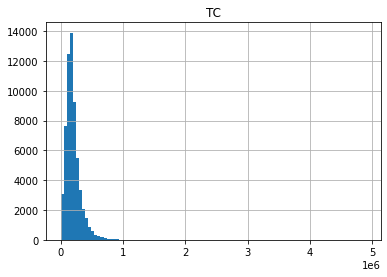

In [23]:
df.hist('TC', bins=100)

In [26]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,TC,Base,Stock,Bonus,yrs_at_company,yoe_total
count,61223.00000,58471.00000,41524.00000,44685.00000,61223.00000,61223.00000
mean,197737.87629,134373.80924,64160.55775,22139.19660,2.23626,5.94945
std,122039.29952,55669.27503,81403.35669,31868.90240,2.85442,5.20653
min,4000.00000,1000.00000,1000.00000,1000.00000,0.00000,0.00000
25%,121000.00000,105000.00000,20000.00000,10000.00000,0.00000,2.00000
50%,175000.00000,135000.00000,40000.00000,16000.00000,1.00000,5.00000
75%,245000.00000,164000.00000,80000.00000,28000.00000,3.00000,9.00000
max,4885000.00000,950000.00000,4200000.00000,4000000.00000,40.00000,45.00000


## Unused EDA Snippets

In [42]:
categories = defaultdict(int)

for row in df['other'].tolist():
    if isinstance(row, list):
        for item in row:
            if ':' in item:
                categories[item.split(':')[0].strip().lower()] += 1

In [44]:
attributes = []
for row in df['other'].tolist():
    if isinstance(row, list):
        for item in row:
            item = item.lower()
            if 'title' not in item and 'race' not in item and 'academic' not in item and 'remote' not in item:
                attributes.append(item)
attributes

['$15000 sign-on bonus',
 '10k relocation bonus',
 ' negotiated amount: $7k',
 '20k relocation bonus',
 'bonus includes $31712 sign on bonus',
 '30000 sign on',
 '+75000 sign-on bonus',
 ' negotiated amount: $10k',
 '$4700 joining bonus',
 ' negotiated amount: $46.7k',
 '$5000 sign-on bonus for application software engineer (l2)',
 '$1500 wfh/wellness reimbursement',
 ' fully paid transit pass',
 '$30k signing bonus (not included in the other numbers)',
 ' tc negotiated up',
 ' negotiated amount: $18k',
 ' advisory',
 '$7k relocation bonus',
 ' negotiated amount: $1.3k',
 '8k relocation bonus',
 ' 40k joining bonus',
 'services team',
 '7000 relocation',
 'sign on: 15k; relocation: 10k',
 ' staff',
 '$10k relo',
 '$5500 or relocation benefits',
 ' negotiated amount: $5k',
 'additional $2266 joining bonus',
 '6k relocation budget',
 ' cash out half of what goes unused',
 'stub year bonus is $40k pro-rated. sign-on bonus is $25k. relocation bonus is $5k.',
 '15k signing bonus',
 '$20k si

# Old

In [ ]:
with open('data/salaryData.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df

In [20]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

,Company,Location,Date,Level,Title,YOE,TC,Base,Stock,Bonus,Details,Gender
0,Veracode,"Burlington, MA",2022-01-30,L1,API Development (Back-End),0 / 1,"$120,000",120k,NaN,NaN,"Remote, Title: Software Engineer, Race: White,...",Gender: Male
1,IBM,"Rochester, MN",2022-01-30,Staff Engineer,Distributed Systems (Back-End),0 / 0,"$112,000",112k,NaN,NaN,"$15,000 sign-on bonus, Title: Software Develop...",Gender: Male
2,Philips,"Cambridge, MA",2022-01-30,L4,Data,2 / 3,"$122,000",111k,NaN,11k,"10K Relocation Bonus, Title: Cloud Software De...",Gender: Male
3,Teleport,"Oakland, CA",2022-01-30,L3,Site Reliability (SRE),1 / 8,"$180,000",180k,NaN,NaN,"Title: Sre, Race: White, Academic Level: Bache...",Gender: Male
4,IBM,"Rochester, MN",2022-01-30,Advisory Engineer,API Development (Back-End),7 / 7,"$128,000",128k,NaN,NaN,"Title: Advisory Software Developer, Race: Whit...",Gender: Male
...,...,...,...,...,...,...,...,...,...,...,...,...
46795,Workday,"Pleasanton, CA",2020-03-11,SWE II,Android,3 / 3,"$145,000",110k,25k,10k,NaN,NaN
46796,Qualcomm,"Boulder, CO",2020-03-11,Engineer,Networking,0 / 0,"$105,000",90k,15k,NaN,Masters,Gender: Male
46797,Guidewire,"San Mateo, CA",2020-03-11,Senior,API Development (Back-End),5 / 13,"$197,000",161k,20k,16k,Masters,Gender: Male
46798,Microsoft,"Redmond, WA",2020-03-11,59,ML / AI,0 / 0,"$160,000",110k,35k,15k,"Joining Bonus of $50,000 to be paid over 2 yea...",Gender: Male


In [5]:
df[(df['company'] == 'Amazon') & (df['title'] == "Software Engineer")].tail(50)

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber
61781,2021-08-10 15:30:22,Amazon,L5,Software Engineer,232,"Newark, NJ",3,3,Full Stack,176,53,3,Male,mcloiapt,1288,501,82641
61796,2021-08-10 16:41:53,Amazon,L4,Software Engineer,166,"Seattle, WA",6,1,Distributed Systems (Back-End),99,45,22,Male,jeiady traiall schmaol schriouw knapp mccleos ...,11527,819,82657
61854,2021-08-11 03:38:38,Amazon,L5,Software Engineer,220,"Sydney, NS, Australia",16,0,Distributed Systems (Back-End),160,29,31,,klesp sqaiantly mcuops kwaum,1311,0,82738
61887,2021-08-11 09:22:30,Amazon,SDE I,Software Engineer,176,"Seattle, WA",1,1,Full Stack,127,41,8,Male,nips schlioc shaay spraorry typehn smaiart hyd...,11527,819,82780
61904,2021-08-11 10:47:17,Amazon,L5,Software Engineer,238,"San Diego, CA",3,0,Security,167,48,23,Female,khiough pfaiv schneent xaemp yiady pholly phearth,7416,825,82801
61907,2021-08-11 12:05:32,Amazon,L5,Software Engineer,242,"Seattle, WA",4,4,Distributed Systems (Back-End),127,115,0,,cleency scraesk shraiacy,11527,819,82805
61908,2021-08-11 12:16:06,Amazon,L6,Software Engineer,270,"Seattle, WA",11,9,Full Stack,89,175,6,Male,rhaor briit thruc tseind mcmoary khoosch grerd...,11527,819,82807
61965,2021-08-11 19:00:13,Amazon,L4,Software Engineer,193,"Seattle, WA",0,0,Web Development (Front-End),162,31,0,Male,leiry mcdeulls scriids stiecy synin,11527,819,82886
61973,2021-08-11 20:52:38,Amazon,L5,Software Engineer,283,"Irvine, CA",2,2,Testing (SDET),194,74,15,Male,schraeps squiss mckaiox feiamp dynoialy sproil...,7229,803,82896
61977,2021-08-11 21:37:59,Amazon,L4,Software Engineer,166,"Seattle, WA",0,0,Full Stack,125,11,30,,skoiaf hypunt pluly juopt rhord hraiows feibs ...,11527,819,82902


In [11]:
df['gender'].value_counts()

Male                               35702
                                   19540
Female                              6999
Other                                400
Title: Senior Software Engineer        1
Name: gender, dtype: int64

In [13]:
df['timestamp'].max()

Timestamp('2021-08-17 08:28:57')

In [4]:
df = df.replace('', np.nan)
df.isna().sum()

timestamp                      0
company                        0
level                          0
title                          0
totalyearlycompensation        0
location                       0
yearsofexperience              0
yearsatcompany                 0
tag                          786
basesalary                     0
stockgrantvalue                0
bonus                          0
gender                     19540
otherdetails               22503
cityid                         0
dmaid                          2
rowNumber                      0
dtype: int64